In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

from torchvision import transforms

from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])




# Train folder load
full_train_dataset = ImageFolder(root="facial expression/train", transform=transform_train)

# Validation ke liye split ratio
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 22967, Validation dataset size: 5742


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(root='facial exp/DATASET/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='facial exp/DATASET/test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Classes: {train_dataset.classes}")


Classes: ['1', '2', '3', '4', '5', '6', '7']


In [5]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes
model = model.to(device)


In [6]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes
model = model.to(device)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [9]:
import matplotlib.pyplot as plt

num_epochs = 30
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

print("Finished Training")


Epoch [1/30], Loss: 217.1549, Train Acc: 59.02%, Val Acc: 69.23%
Epoch [2/30], Loss: 166.3259, Train Acc: 68.90%, Val Acc: 72.62%
Epoch [3/30], Loss: 149.6895, Train Acc: 72.37%, Val Acc: 73.44%
Epoch [4/30], Loss: 139.8101, Train Acc: 74.08%, Val Acc: 74.80%
Epoch [5/30], Loss: 132.3307, Train Acc: 75.71%, Val Acc: 71.19%
Epoch [6/30], Loss: 127.5104, Train Acc: 76.68%, Val Acc: 79.76%
Epoch [7/30], Loss: 123.1724, Train Acc: 76.85%, Val Acc: 74.35%
Epoch [8/30], Loss: 118.7567, Train Acc: 77.66%, Val Acc: 75.68%
Epoch [9/30], Loss: 112.5490, Train Acc: 79.07%, Val Acc: 80.80%
Epoch [10/30], Loss: 111.5252, Train Acc: 79.11%, Val Acc: 81.10%
Epoch [11/30], Loss: 93.7981, Train Acc: 82.90%, Val Acc: 83.57%
Epoch [12/30], Loss: 87.9455, Train Acc: 83.68%, Val Acc: 81.88%
Epoch [13/30], Loss: 85.6751, Train Acc: 84.26%, Val Acc: 83.47%
Epoch [14/30], Loss: 83.2162, Train Acc: 84.17%, Val Acc: 82.53%
Epoch [15/30], Loss: 80.3629, Train Acc: 85.23%, Val Acc: 83.21%
Epoch [16/30], Loss: 76.

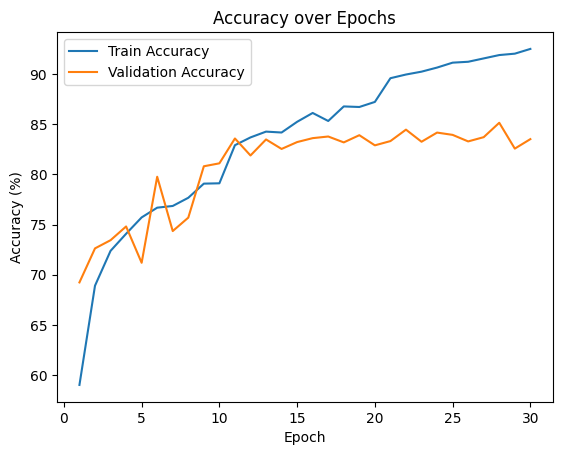

In [10]:
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


In [11]:
torch.save(model.state_dict(), 'emotion_cnn_final.pth')


In [12]:
model.load_state_dict(torch.load('emotion_cnn_final.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load base model (e.g., ResNet18)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)   # 7 emotions

# Load weights
model.load_state_dict(torch.load('emotion_cnn_final.pth', map_location=device))
model = model.to(device)
model.eval()


C:\Users\LOQ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LOQ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
from torchvision import transforms
from PIL import Image
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 emotions
model.load_state_dict(torch.load('emotion_cnn_final.pth', map_location=device))
model = model.to(device)
model.eval()

# Emotion dict
emotion_dict = {
    1: "Surprise",
    2: "Fear",
    3: "Disgust",
    4: "Happy",
    5: "Sad",
    6: "Angry",
    7: "Neutral"
}

# Image
img_path = "facial exp/DATASET/test/4/test_0026_aligned.jpg"
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = Image.open(img_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    emotion_class = predicted.item()

print("Predicted emotion index:", emotion_class)
print("Predicted emotion label:", emotion_dict[emotion_class + 1])


Predicted emotion index: 3
Predicted emotion label: Happy


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []


In [22]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:   # ⚡ test_loader bana lo test dataset ke liye
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [23]:
cm = confusion_matrix(all_labels, all_preds)


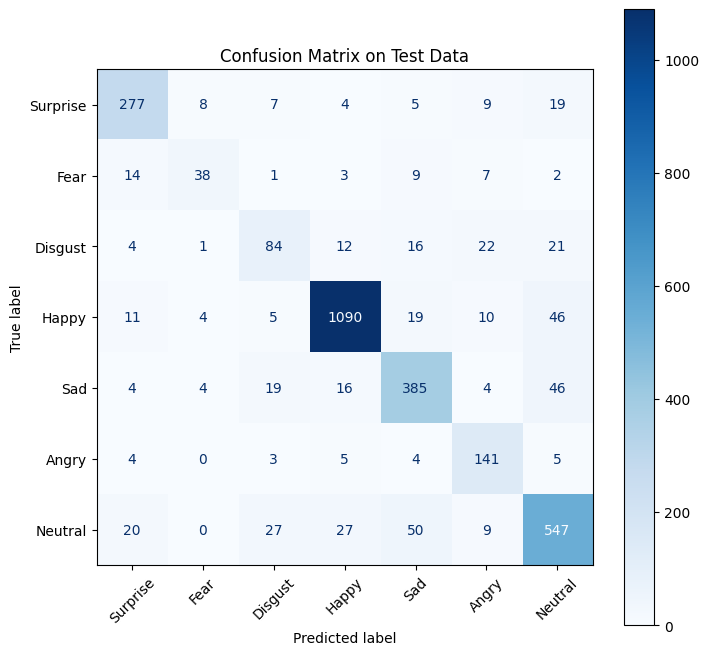

In [24]:
emotions = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Angry", "Neutral"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix on Test Data")
plt.show()


In [25]:
torch.save(model.state_dict(), 'emotion_cnn_final.pth')
print("Model saved ✅")


Model saved ✅
